# Rozpoznawanie rodzajów lokomotyw
## Zaawansowane metody sztucznej inteligencji
### Kamil Sakowicz 99971

### Import bibliotek

In [134]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa

keras = tf.keras
layers = tf.keras.layers


### Zdefiniowanie stałych globalnych

In [135]:
DATASET_DIR = os.path.join("..", "loko")
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 0.00001
AUGMENTATIONS_PER_IMAGE = 10

### Wstępne przetworzenie obrazu - przetwarzamy obrazy w taki sposób, żeby miały stały rozmiar oraz kolory

In [136]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Error reading image: {image_path}")
        return None

    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0

    return img

### Augmentacja obrazów - mamy mały zbiór obrazów, dzięki augmentacji możemy uzyskać większą ilość danych do trenowania modeli

In [137]:
def augment_images():
    return iaa.Sequential([
        # Transformacje geometryczne
        iaa.Affine(
            rotate=(-20, 20),  # Rotacja między -20 a 20 stopni
            scale=(0.8, 1.2),  # Przeskalowanie obrazu
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}  # Translacja
        ),

        # Augmentacje kolorowe
        iaa.Sometimes(0.5, iaa.AddToHueAndSaturation((-20, 20))),
        iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 1.0))),

        # Jasność i kontrast
        iaa.Sometimes(0.4, iaa.LinearContrast((0.75, 1.5))),
        iaa.Sometimes(0.4, iaa.Multiply((0.8, 1.2))),

        # Szum
        iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(scale=0.05 * 255)),

        # Transformacja perspektywy
        iaa.Sometimes(0.3, iaa.PerspectiveTransform(scale=(0.01, 0.1)))
    ])


### Przygotowanie zbioru danych - ustalamy etykiety na podstawie katalogu, stosujemy augmentacje, tworzymy zbiór treningowy i walidacyjny

In [138]:

def prepare_dataset(dataset_dir):
    augmentation_pipeline = augment_images()
    loco_types = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    images = []
    labels = []

    label_to_index = {loco_type: idx for idx, loco_type in enumerate(loco_types)}

    for loco_type in loco_types:
        loco_dir = os.path.join(dataset_dir, loco_type)

        for img_name in os.listdir(loco_dir):
            img_path = os.path.join(loco_dir, img_name)

            original_img = preprocess_image(img_path)

            if original_img is not None:
                images.append(original_img)
                labels.append(label_to_index[loco_type])

                for _ in range(AUGMENTATIONS_PER_IMAGE):
                    img_aug = (original_img * 255).astype(np.uint8)

                    augmented_img = augmentation_pipeline(image=img_aug)

                    augmented_img = augmented_img.astype(np.float32) / 255.0

                    images.append(augmented_img)
                    labels.append(label_to_index[loco_type])

    images = np.array(images)
    labels = np.array(labels)

    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=0.2, random_state=42
    )

    return (X_train, y_train), (X_val, y_val), loco_types

### Stworzenie modelu - na podstawie modelu bazowego tworzymy model, którego będziemy używać do rozpoznawania lokomotyw

In [139]:
def create_transfer_learning_model(base_model_func, num_classes):
    base_model = base_model_func(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Trenowanie modelu - podany model trenujemy na podanych zbiorach danych

In [140]:
def train_model(model, X_train, y_train, X_val, y_val):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10).batch(BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS
    )

    return history

### Funkcja tworząca wykresy na podstawie danych uzyskanych podczas trenowania modeli

In [141]:
def plot_training_histories(histories, model_names):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} - Training Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} - Validation Accuracy')
    plt.title('Model Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 1, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} - Training Loss')
        plt.plot(history.history['val_loss'], label=f'{name} - Validation Loss')
    plt.title('Model Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Przewidywanie modelu lokomotywy

In [142]:

def create_predictor(model, loco_types):

    # wczytanie i przetworzenie pliku, aby był zgodny z danymi, na których był trenowany model
    def preprocess_image(image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Error: Image file not found at {image_path}")

        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Error: Unable to read image at {image_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0

        return img.astype(np.float32)

    def predict_locomotive(image_path):
        try:
            img = preprocess_image(image_path)
            img = np.expand_dims(img, axis=0)

            prediction = model.predict(img)
            class_index = np.argmax(prediction)

            if class_index >= len(loco_types):
                raise IndexError(f"Error: Predicted index {class_index} out of bounds for loco_types.")

            class_name = loco_types[class_index]
            confidence = float(prediction[0][class_index])

            return class_name, confidence

        except Exception as e:
            return str(e), 0.0

    return predict_locomotive


### Włączenie programu

Locomotive Types: ['steam', 'eu07', 'et22', 'sm42', 'ep09']
Training samples: 880
Validation samples: 220

Training MobileNetV2 model...
Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.2507 - loss: 1.8961 - val_accuracy: 0.4364 - val_loss: 1.4097
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3546 - loss: 1.6257 - val_accuracy: 0.5545 - val_loss: 1.2642
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3743 - loss: 1.4612 - val_accuracy: 0.5864 - val_loss: 1.1791
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4651 - loss: 1.2827 - val_accuracy: 0.6091 - val_loss: 1.1144
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4591 - loss: 1.2611 - val_accuracy: 0.6364 - val_loss: 1.0635
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6422 - loss: 1.0510
MobileNetV2 - Validation Accuracy: 63.64%

Training ResNet50 model...
Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 0.2568 - loss:

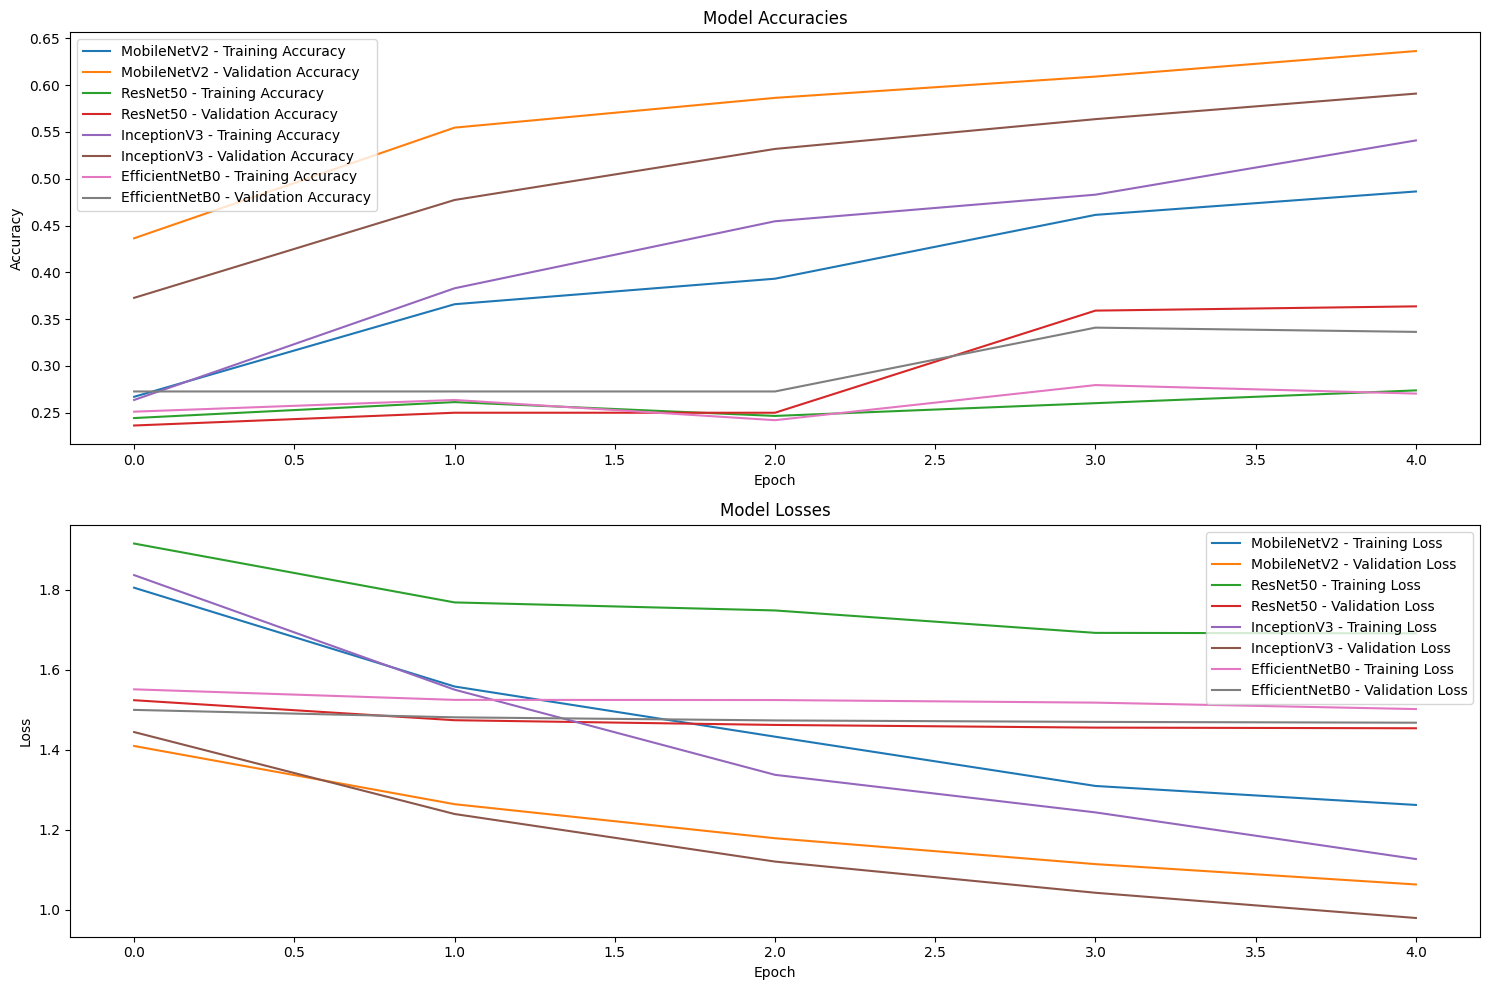


Best performing model: MobileNetV2


In [143]:
(X_train, y_train), (X_val, y_val), loco_types = prepare_dataset(DATASET_DIR)

print("Locomotive Types:", loco_types)
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])

models_to_compare = [
    ('MobileNetV2', tf.keras.applications.MobileNetV2),
    ('ResNet50', tf.keras.applications.ResNet50),
    ('InceptionV3', tf.keras.applications.InceptionV3),
    ('EfficientNetB0', tf.keras.applications.EfficientNetB0)
]

histories = []
trained_models = []

for model_name, base_model_func in models_to_compare:
    print(f"\nTraining {model_name} model...")

    model = create_transfer_learning_model(base_model_func, len(loco_types))
    history = train_model(model, X_train, y_train, X_val, y_val)

    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"{model_name} - Validation Accuracy: {val_accuracy * 100:.2f}%")

    histories.append(history)
    trained_models.append(model)

plot_training_histories(histories, [name for name, _ in models_to_compare])

best_model_index = [history.history['val_accuracy'][-1] for history in histories].index(
    max([history.history['val_accuracy'][-1] for history in histories]))
best_model = trained_models[best_model_index]
best_model_name = models_to_compare[best_model_index][0]

print(f"\nBest performing model: {best_model_name}")

predict_loco_type = create_predictor(best_model, loco_types)

# Zapisanie najlepszego modelu
best_model.save(f'{best_model_name.lower()}_locomotive_detection_model.h5')

In [144]:
# Przewidywanie rodzaju lokomotywy
test_image_path = os.path.join('..', 'predict/eu.jpeg')
locomotive_type, confidence = predict_loco_type(test_image_path)
print(f"Predicted Locomotive Type: {locomotive_type}")
print(f"Confidence: {confidence * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted Locomotive Type: et22
Confidence: 37.97%
